# 식당 외관 이미지 분류

In [66]:
import tensorflow as tf  # 텐서플로 라이브러리
import numpy as np  # 배열 계산 넘파이 라이브러리
import matplotlib.pyplot as plt  # 시각화 라이브러리
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import optimizers, metrics  # 모델 훈련
from keras.layers import LeakyReLU
import torch.cuda

# import splitfolders
# splitfolders.ratio('./train2/train',output='./train',seed=580,ratio=(0.8,0.2))

print(torch.cuda.is_available())
print(tf.test.is_built_with_gpu_support())
print(tf.test.gpu_device_name())
print(torch.cuda.get_device_name(torch.cuda.current_device()))

True
True
/device:GPU:0
NVIDIA GeForce RTX 3050 Laptop GPU


In [67]:
np.random.seed(42) # 서로 다른 동일한 셋트리의 고정된 난수 생성
tf.random.set_seed(42) # 위와 동일

train_datagen = ImageDataGenerator(rescale=1./255, # 1/255로 스케일링 하여 0~255 -> 0~1 범위로 변환
                                  horizontal_flip=True, # (True) 1/2 확률로 이미지를 수평으로 뒤집음
                                  width_shift_range=0.1, # 그림을 수평 또는 수직으로 랜덤하게 평행 이동
                                  height_shift_range=0.1, # 위와 동일
                                  fill_mode='nearest') # 이미지를 회전, 이동하거나 축소할 때 생기는 공간을 채움

# 1. IDG가 이미지 파일들을 Numpy Array 형태로 가져온 후 사용자가 설정한 여러가지 증강 기법을 적용할 준비를 함(객체 생성)
# 2. flow_from_directory로 Numpy Array Iterator 객체를 만들어줌. X(image)array, Y(label)array, 배치 사이즈, 데이터 셔플 유무 설정
# 설계한 모델에 fit(_generator)를 호출하면 1,2번 단계가 수행되고 설정된 배치 사이즈 만큼의 Numpy Array 를 Tensor로 바꾸고 본격적인 학습 시작


train_generator = train_datagen.flow_from_directory(
       directory='./train/train',
       target_size=(227, 227), # 사용할 CNN 모델 입력 사이즈에 맞게 resize 
       batch_size=4, # 이미지 데이터 원본 소스에서 한번에 얼만큼의 이미지 데이터를 가져올 것인지
       class_mode='categorical') # 'binary' : 0 or 1 이진 분류 클래스 / 'categorical' : 멀티-레이블 클래스, 원-핫 인코딩된 형테(자연어) / 'sparse' : 멀티-레이블, 레이블 인코딩 된 형태


test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
       directory='./train/val',
       target_size=(227, 227),
       batch_size=4,
       class_mode='categorical')



# x,y = train_generator.next() # train_set의 이미지 데이터 전부

# for i in range(len(x)):  
#     print(x[i].shape)
#     print(y[i])
#     plt.imshow(x[i])
#     plt.show()


# 데이터 라벨 수가 30개 정도로 상당히 부족하기에 과적합을 피하기 위해 드롭아웃을 0.5로 잡음
model = Sequential() # 입력의 데이터 채널 수와 필터의 채널 수가 같아야 함.
model.add(Conv2D(114, (3, 3), input_shape=(227,227,3),strides = 4,activation = 'relu')) # 3차원이므로(입력 데이터 채널 수: 3) 필터는 3개 / RGB는 3차원 흑백은 1차원
# Conv2D는 입/출력 모두 3차원 데이터로 처리 / Conv2D 필터 개수 구하는 식 : ((이미지 size - 커널 size + 2*패딩 size) / strides size ) + 1
model.add(MaxPooling2D(pool_size=(2, 2))) # pooling을 하게 되면 28x28x3의 데이터는 14x14x3로 사이즈는 줄어들지만 개수는 늘어나기에 다음 레이어의 필터 수는 (2x2)만큼 늘려서 처리해야함
BatchNormalization()
model.add(Activation(LeakyReLU(alpha=0.1)))
model.add(Dropout(0.5))

model.add(Conv2D(228, (3, 3),strides = 2 ,activation = 'relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
BatchNormalization()
model.add(Activation(LeakyReLU(alpha=0.1)))
model.add(Dropout(0.5))

model.add(Conv2D(114, (3, 3) ,activation = 'relu'))
BatchNormalization()
model.add(Activation(LeakyReLU(alpha=0.1)))
model.add(Dropout(0.5))



model.add(Flatten()) # 1차원 형태의 배열로 변환
model.add(Dense(57))
BatchNormalization()
model.add(Activation(LeakyReLU(alpha=0.1)))
model.add(Dropout(0.5))
model.add(Dense(5))
model.add(Activation('sigmoid'))


model.summary()


model.compile(loss='MSE', optimizer=optimizers.Adam(learning_rate=0.0005), metrics=['accuracy'])

history = model.fit_generator(
       train_generator,
       steps_per_epoch=len(train_generator),
       epochs=100,
       validation_data=test_generator,
       validation_steps=10)


acc= history.history['accuracy'] 
val_acc= history.history['val_accuracy'] 
y_vloss = history.history['val_loss']

y_loss = history.history['loss']

Found 246 images belonging to 5 classes.
Found 59 images belonging to 5 classes.
Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_30 (Conv2D)          (None, 57, 57, 114)       3192      
                                                                 
 max_pooling2d_20 (MaxPoolin  (None, 28, 28, 114)      0         
 g2D)                                                            
                                                                 
 activation_50 (Activation)  (None, 28, 28, 114)       0         
                                                                 
 dropout_40 (Dropout)        (None, 28, 28, 114)       0         
                                                                 
 conv2d_31 (Conv2D)          (None, 13, 13, 228)       234156    
                                                                 
 max_pooling2d_21 (MaxPoolin  (None, 6

C:\Users\USER\AppData\Local\Temp\ipykernel_3504\857238805.py:77: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


62/62 [==============================] - 5s 67ms/step - loss: 0.1840 - accuracy: 0.1992 - val_loss: 0.1638 - val_accuracy: 0.2500
Epoch 2/100
62/62 [==============================] - 5s 73ms/step - loss: 0.1712 - accuracy: 0.2602 - val_loss: 0.1647 - val_accuracy: 0.2750
Epoch 3/100
62/62 [==============================] - 4s 56ms/step - loss: 0.1669 - accuracy: 0.2317 - val_loss: 0.1621 - val_accuracy: 0.3000
Epoch 4/100
62/62 [==============================] - 4s 59ms/step - loss: 0.1642 - accuracy: 0.2927 - val_loss: 0.1594 - val_accuracy: 0.3750
Epoch 5/100
62/62 [==============================] - 4s 70ms/step - loss: 0.1629 - accuracy: 0.2561 - val_loss: 0.1471 - val_accuracy: 0.4500
Epoch 6/100
62/62 [==============================] - 4s 60ms/step - loss: 0.1636 - accuracy: 0.3333 - val_loss: 0.1412 - val_accuracy: 0.4750
Epoch 7/100
62/62 [==============================] - 4s 66ms/step - loss: 0.1499 - accuracy: 0.3862 - val_loss: 0.1326 - val_accuracy: 0.5000
Epoch 8/100
62/62 

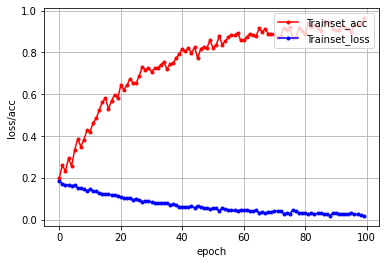

In [71]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
y_vloss = history.history['val_loss']
y_loss = history.history['loss']
x_len = np.arange(len(y_loss))

a = plt.plot(x_len, acc, marker='.', c="red", label='Trainset_acc')
d = plt.plot(x_len, y_loss, marker='.', c="blue", label='Trainset_loss')

plt.legend(loc='upper right')
plt.grid()
plt.xlabel('epoch')
plt.ylabel('loss/acc')
plt.show()


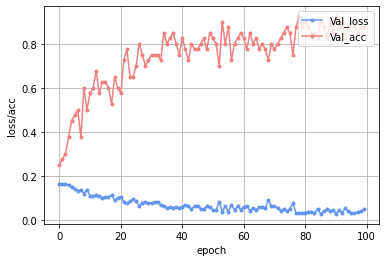

In [72]:
c = plt.plot(x_len, y_vloss, marker='.',
             c="cornflowerblue", label='Val_loss')
b = plt.plot(x_len, val_acc, marker='.', c="lightcoral", label='Val_acc')

plt.legend(loc='upper right')
plt.grid()
plt.xlabel('epoch')
plt.ylabel('loss/acc')
plt.show()


Found 1 images belonging to 1 classes.


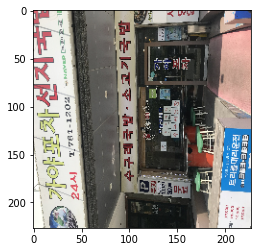

15/15 [==============================] - 1s 31ms/step - loss: 0.0461 - accuracy: 0.8644
[0.04614784196019173, 0.8644067645072937]


In [74]:
from keras.models import load_model

# model.save('new_cnn_model.h5')
# model = load_model('./cnn_save_model/new_cnn_model.h5')

t = ImageDataGenerator(rescale=1./255)

path = './test'
test = t.flow_from_directory(
    path, target_size = (227,227)
)
img = tf.io.read_file('./test/test/KakaoTalk_20220824_111316001.jpg')
img=tf.image.decode_jpeg(img,channels=3) # R,G,B 3개의 채널을 가진 이미지 처리
img=tf.image.convert_image_dtype(img,float) # 정규화(Normalization 0-255 -> 1)
img=tf.image.resize(img,[227,227])# Resize / 기존 : 120 x 120 
plt.imshow(img)
plt.show()


print(model.evaluate(test_generator))

In [77]:
# 제일 높은 정확도의 이미지 분류 모델
model = load_model('./cnn_save_model/new_88%_cnn_model.h5')
model.summary()
print(model.evaluate(test_generator))

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_18 (Conv2D)          (None, 57, 57, 114)       3192      
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 28, 28, 114)      0         
 g2D)                                                            
                                                                 
 activation_30 (Activation)  (None, 28, 28, 114)       0         
                                                                 
 dropout_24 (Dropout)        (None, 28, 28, 114)       0         
                                                                 
 conv2d_19 (Conv2D)          (None, 13, 13, 228)       234156    
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 6, 6, 228)        0         
 g2D)                                                 